# Fitting Potential Energy Surfaces with Machine Learning

In this tutorial we will demonstrate how machine learning can be used to fit potential energy surfaces (PES) obtained from electronic structure calculations. This has the potential to greatly speed up computational discovery of e.g. battery materials, since machine learning algorithms are typically orders of magnitude faster than conventional electronic structure methods. The notebook is based on two different examples. The first example is intended to give the student a conceptual understanding of machine learning methods by fitting a ML potential to a the 2D PES of a single water molecule. Having understood the basic concepts, the second example then considers a more complex physical system based on the alloyed nanoparticles considered in the exercises from the previous days. <br> <br>

The machine learning fits in this notebook are made with the Atomistic Machine Learning Package (AMP) [1], which is an open-source package for atomistic machine learning developed at Brown University. The basic idea behind AMP is shown in the workflow below. It works by taking a set of input structures calculated with an electronic structure method and then transforming these according to a symmetrization scheme that makes them suitable as inputs to a machine learning model. The transformed structures are subsequently fitted with a machine learning model such as a neural network or a kernel-based regression model to output energies and/or forces, which match those obtained from the electronic structure calculations. You can read more about AMP through the link: https://amp.readthedocs.io/en/latest/
<br>
<br>
<br>
<img src="AMP2.png" width = "300" title="AMP Workflow">
<br>
<br>
<img src="AMP1.png" width = "900" title="AMP Logo">
<br>
<br>
<br>

In [18]:
#Start by importing relevant modules

# ase and python stuff
from ase.io import read, write
from ase.visualize import view
%matplotlib inline
import pylab as plt
import numpy as np
from ase.geometry import get_angles
from ase.cluster import Octahedron, Icosahedron, Decahedron
import random
import os
import shutil
from ase.db import connect
from asap3 import EMT as asapEMT
from ase.calculators.singlepoint import SinglePointCalculator as SPC

# AMP stuff
from amp import Amp
from amp.model.neuralnetwork import NeuralNetwork
from amp.descriptor.gaussian import Gaussian, make_symmetry_functions
from amp.model import LossFunction

# Orderings
from orderings import SymmetricOrderingGenerator as SOG
from orderings import RandomOrderingGenerator as ROG

## Example 1: Fitting the 2D PES of a water molecule
We will consider a water molecule as sketched below. We have constructed a data set of 900 different water molecules by varying the H-O-H angle, $\theta$, and the O-H bond distance, r, on an equidistant grid. Energies and forces have subsequently been calculated by employing the PBE functional [3] as implemented in the Vienna Ab Initio Simulation Package (VASP) [4]. By running the two cells below you can visualize the data set using the GUI available within the ASE package [5] and the potential energy surface obtained from the DFT calculations.
<img src="water_molecule.png" width = "300" title="Water Molecule">
<figcaption> Figure taken from [2].</figcaption>



In [19]:
#Read in and visualize the data set with the ASE GUI
images = read('water_molecule.traj', index = ':')
view(images) 

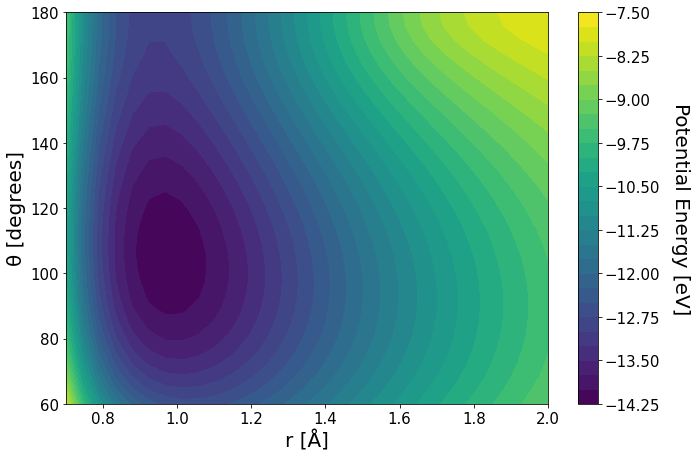

In [5]:
#Visualize potential energy surface
distances = []
angles = []
energies = []
for atoms in images:
    v1 = [atoms.get_positions()[2]- atoms.get_positions()[0]]
    v2 = [atoms.get_positions()[1]- atoms.get_positions()[0]]
    angle = get_angles(v1, v2)
    distance = np.linalg.norm(v1)
    distances.append(distance)
    angles.append(angle)
    energies.append(atoms.get_potential_energy())

r = np.reshape(distances, (30,30))
theta = np.reshape(angles, (30,30))
E = np.reshape(energies, (30, 30))


plt.contourf(r, theta, E, 30)
plt.xlabel('r [Å]', fontsize = 20)
plt.ylabel('θ [degrees]', fontsize = 20)
cbar = plt.colorbar()
cbar.set_label('Potential Energy [eV]', fontsize = 20, rotation=270, labelpad = 30)
cbar.ax.tick_params(labelsize=15) 
fig = plt.gcf()
plt.tick_params(labelsize = 15)
size = fig.get_size_inches()
fig.set_size_inches(size*1.8)
plt.show()

### Step 1: Selecting the training and test set
In order to perform machine learning on the water molecule data set, we must select a training set for fitting our machine learning model. The best fit to the data is of course obtained by selecting all 900 images, but that is not very interesting. A more interesting approach is to select only a small subset as training data and subsequently evaluate the predictions of the machine learning model on the full data set. This will give an idea of the interpolation and extrapolation capabilities of our machine learning approach. <br>
By running the cell below a random subset of N_train images are selected from the parent data set and the chosen data points are visualized on the PES plot from before. We have here chosen a rather small value of N_train but it is encouraged to play around with this parameter in the end of the tutorial.

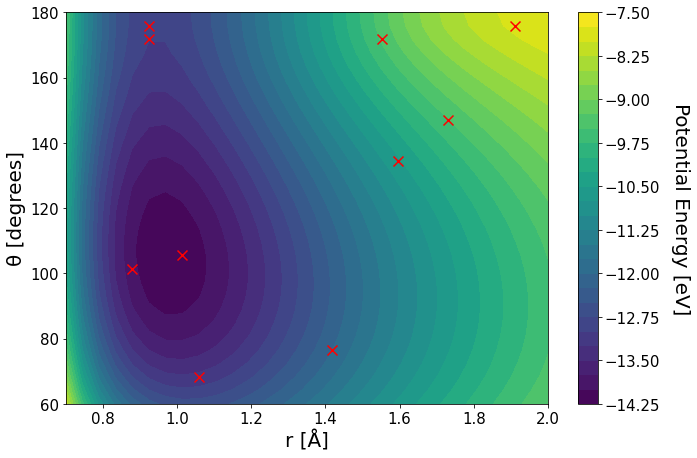

In [20]:
# Training images

N_train = 10 #number of training images

images_random = images.copy()
random.shuffle(images_random)
train_images = images_random[0:N_train]


# Visualize the previous potential energy surface with selected training points
distances_train = []
angles_train = []
for atoms in train_images:
    v1 = [atoms.get_positions()[2]- atoms.get_positions()[0]]
    v2 = [atoms.get_positions()[1]- atoms.get_positions()[0]]
    angle = get_angles(v1, v2)
    distance = np.linalg.norm(v1)
    distances_train.append(distance)
    angles_train.append(angle)
    
    
plt.contourf(r, theta, E, 30)
plt.xlabel('r [Å]', fontsize = 20)
plt.ylabel('θ [degrees]', fontsize = 20)
cbar = plt.colorbar()
cbar.set_label('Potential Energy [eV]', fontsize = 20, rotation=270, labelpad = 30)
cbar.ax.tick_params(labelsize=15) 
fig = plt.gcf()
plt.tick_params(labelsize = 15)
size = fig.get_size_inches()
fig.set_size_inches(size*1.8)
plt.scatter(distances_train, angles_train, color ='r', marker = 'x', s = 100)
plt.xlim((min(distances), max(distances)))
plt.ylim((min(angles), max(angles)))
plt.show()

### Step 2: Fingerprinting the training data
In order to make the training data suitable as input to a regression model, we will need to fingerprint it. In short, this means taking the raw cartesian coordinates of the structures and transforming them in a way that leaves the coordinates invariant to translation and rotation. There exist several possible symmetrization schemes in litterature. We will here employ a Gaussian fingerprinting scheme as suggested by Behler et. al [6]. The theory behind these fingerprints are described thoroughly in the AMP documentation: https://amp.readthedocs.io/en/latest/theory.html <br> For our purpose, it is enough to know that there are two types of Gaussian fingerprints, G2 and G4, which take 2-body and 3-body interactions for each atom into account, respectively. These are displayed in the figure below. The Gaussian descriptors are parametrized by the parameters $\eta, \zeta, \gamma$, which serve as hyperparameters for fingerprinting the chemical environment of each atom. Furthermore one has to specify a cutoff radius, which determines the extent of the local chemical environment of each atom. The larger cutoff and the more values of $\eta, \zeta, \gamma$ that are included, the more detailed the description of the chemical environments typically becomes. This comes at a cost however, since this also makes the machine learning model more computationally demanding. It is encouraged to play around with the fingerprinting at the end of this tutorial.

<br>
<br>
<img src="AMP3.png" width = "1100" title="AMP Workflow">
<br>
<br>

In [25]:
# Fingerprints
elements = ['H', 'O'] # Fingerprints will be generated for the elements H and O


G = make_symmetry_functions(elements=elements, type='G2',
                             etas=[0.005, 4.0, 20.0, 80.0]) #This function generates G2-type fingerprints for the H and O atoms using the values of eta chosen


G += make_symmetry_functions(elements=elements, type='G4',
                             etas=[0.005],
                             zetas=[1., 4.],
                             gammas=[+1., -1.]) #This function generates G4-type fingerprints for the H and O atoms using the values of eta, lambda and gamma chosen

cutoff = 4.0 #Cutoff radius for the Gaussian fingerprints
print(G)

[{'type': 'G2', 'element': 'H', 'eta': 0.005}, {'type': 'G2', 'element': 'O', 'eta': 0.005}, {'type': 'G2', 'element': 'H', 'eta': 4.0}, {'type': 'G2', 'element': 'O', 'eta': 4.0}, {'type': 'G2', 'element': 'H', 'eta': 20.0}, {'type': 'G2', 'element': 'O', 'eta': 20.0}, {'type': 'G2', 'element': 'H', 'eta': 80.0}, {'type': 'G2', 'element': 'O', 'eta': 80.0}, {'type': 'G4', 'elements': ['H', 'H'], 'eta': 0.005, 'gamma': 1.0, 'zeta': 1.0}, {'type': 'G4', 'elements': ['H', 'O'], 'eta': 0.005, 'gamma': 1.0, 'zeta': 1.0}, {'type': 'G4', 'elements': ['O', 'O'], 'eta': 0.005, 'gamma': 1.0, 'zeta': 1.0}, {'type': 'G4', 'elements': ['H', 'H'], 'eta': 0.005, 'gamma': -1.0, 'zeta': 1.0}, {'type': 'G4', 'elements': ['H', 'O'], 'eta': 0.005, 'gamma': -1.0, 'zeta': 1.0}, {'type': 'G4', 'elements': ['O', 'O'], 'eta': 0.005, 'gamma': -1.0, 'zeta': 1.0}, {'type': 'G4', 'elements': ['H', 'H'], 'eta': 0.005, 'gamma': 1.0, 'zeta': 4.0}, {'type': 'G4', 'elements': ['H', 'O'], 'eta': 0.005, 'gamma': 1.0, 'z

### Step 3: Fitting the data with a neural network
We are now ready to fit our data with a neural network. By running the cell below a neural network with two hidden layers and 5 nodes in each is fitted to the data. We have in this case chosen to fit only the energies in the data set but at the end of this tutorial it is encouraged to try including forces in the fit also. This is done by changing the value of force_rmse to some specified threshold. 

In [26]:
# Neural network
hiddenlayers = (5,5)

# Convergence parameters for the fit. 
energy_rmse = 0.005 # Root-mean-square errors of the energies
force_rmse = None # Root-mean-square error of the forces. Change this enable force training.
energy_maxresid = None # Maximum residual of energies
force_maxresid = None  # Maximum residual of forces

convergence = {'energy_rmse': energy_rmse,
               'force_rmse': force_rmse,
               'energy_maxresid': energy_maxresid,
               'force_maxresid': force_maxresid}
print({elements[0]: G, elements[1]: G})
calc = Amp(descriptor = Gaussian(Gs = {elements[0]: G, elements[1]: G}, cutoff = cutoff),
           cores = 1,
           model = NeuralNetwork(hiddenlayers = hiddenlayers))

calc.model.lossfunction = LossFunction(convergence = convergence)

print('Training initated.. this will take a few seconds...')
calc.train(images = train_images)
print('Training completed.')

{'H': [{'type': 'G2', 'element': 'H', 'eta': 0.005}, {'type': 'G2', 'element': 'O', 'eta': 0.005}, {'type': 'G2', 'element': 'H', 'eta': 4.0}, {'type': 'G2', 'element': 'O', 'eta': 4.0}, {'type': 'G2', 'element': 'H', 'eta': 20.0}, {'type': 'G2', 'element': 'O', 'eta': 20.0}, {'type': 'G2', 'element': 'H', 'eta': 80.0}, {'type': 'G2', 'element': 'O', 'eta': 80.0}, {'type': 'G4', 'elements': ['H', 'H'], 'eta': 0.005, 'gamma': 1.0, 'zeta': 1.0}, {'type': 'G4', 'elements': ['H', 'O'], 'eta': 0.005, 'gamma': 1.0, 'zeta': 1.0}, {'type': 'G4', 'elements': ['O', 'O'], 'eta': 0.005, 'gamma': 1.0, 'zeta': 1.0}, {'type': 'G4', 'elements': ['H', 'H'], 'eta': 0.005, 'gamma': -1.0, 'zeta': 1.0}, {'type': 'G4', 'elements': ['H', 'O'], 'eta': 0.005, 'gamma': -1.0, 'zeta': 1.0}, {'type': 'G4', 'elements': ['O', 'O'], 'eta': 0.005, 'gamma': -1.0, 'zeta': 1.0}, {'type': 'G4', 'elements': ['H', 'H'], 'eta': 0.005, 'gamma': 1.0, 'zeta': 4.0}, {'type': 'G4', 'elements': ['H', 'O'], 'eta': 0.005, 'gamma': 1

### Step 4: Inspecting the training sesssion
During the training session the results were written the .txt file amp-log.txt. This file contains information about our model and shows the loss function optimization that happens when the neural network is fitted to the data. By running the cell below the contents of the file will be printed and may be inspected.

In [23]:
# Inspecting the training session

f = open('amp-log.txt', 'r')
filecontents = f.read()
print(filecontents)


   oo      o       o   oooooo
  o  o     oo     oo   o     o
 o    o    o o   o o   o     o
o      o   o  o o  o   o     o
oooooooo   o   o   o   oooooo
o      o   o       o   o
o      o   o       o   o
o      o   o       o   o

Amp: Atomistic Machine-learning Package
Developed by Andrew Peterson, Alireza Khorshidi, and others,
Brown University.
PI Website: http://brown.edu/go/catalyst
Official repository: http://bitbucket.org/andrewpeterson/amp
Official documentation: http://amp.readthedocs.org/
Citation:
  Alireza Khorshidi & Andrew A. Peterson,
  Computer Physics Communications 207: 310-324 (2016).
  http://doi.org/10.1016/j.cpc.2016.05.010
User: changai
Hostname: n-62-27-22
Date: 2021-03-19T13:05:43 (2021-03-19T12:05:43 UTC)
Architecture: x86_64
PID: 14567
Amp version: 0.6.1
Amp directory: /zhome/43/5/58576/bike-2021-venv-GA-AMP/lib/python3.6/site-packages/amp
 Last commit: b'unknown hash'
 Last commit date: b'unknown date'
Python: v3.6.13: /zhome/43/5/58576/bike-2021-venv-GA-AMP/

### Step 5: Visualizing the Results
Having fitted our machine learning model we are now ready to evaluate its performance on the full data set. This is done by loading the trained machine learning model saved as amp.amp. This file works as an ASE calculator, which can be used to calculate forces and energies for a structure through the commands atoms.get_potential_energy() and atoms.get_forces(). In the cells below we plot the potential energy surface of our original DFT data set along with the one predicted by AMP. The predicted minimum energy structure for each model is indicated with an asterisk. The final plot shows the absolute difference between the two along with a scatter plot of our training points. Where does our machine learning model perform well and where does it fail? Try running the notebook a few times and see if the conclusions change. 

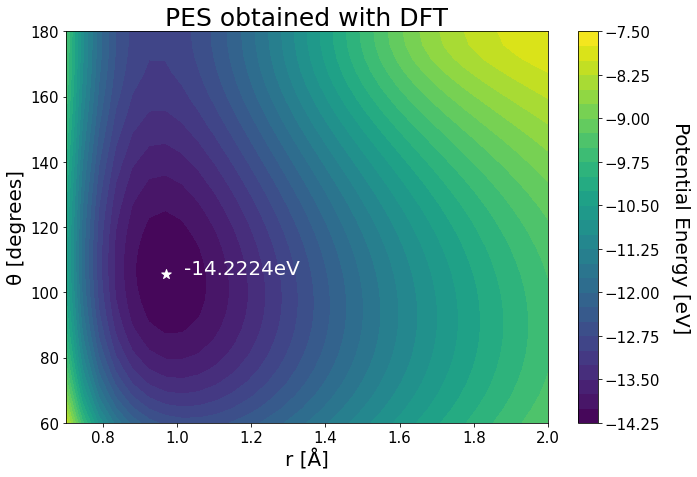

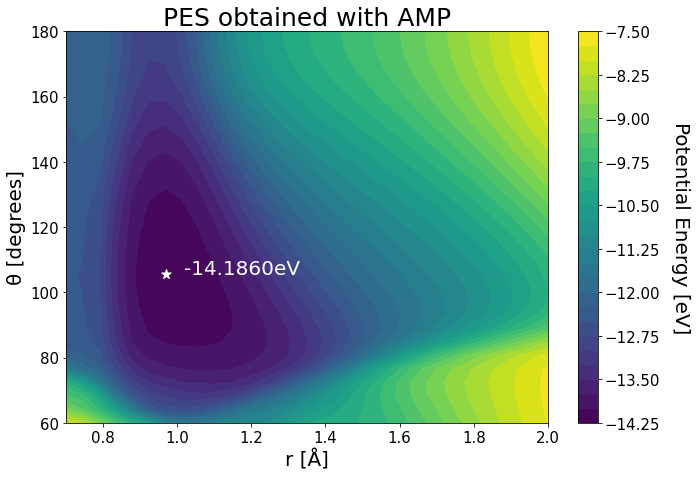

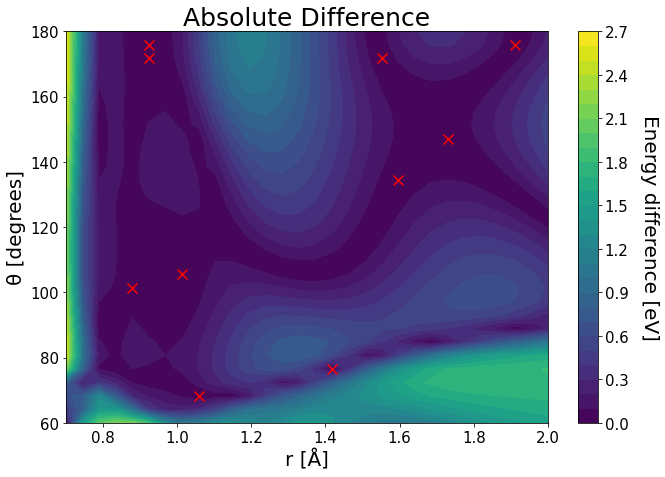

In [24]:
# Load AMP calculator and predict energies for entire data set
calc = Amp.load('amp.amp', cores = 1)

images_amp = [atoms.copy() for atoms in images]
energies_amp = []
for atoms in images_amp:
    atoms.calc = calc
    energies_amp.append(atoms.get_potential_energy())

E_amp = np.reshape(energies_amp, (30, 30))


# Get minimum DFT energy
E_min = np.min(E)
r_min = r[np.unravel_index(np.argmin(E, axis=None), E.shape)]
theta_min = theta[np.unravel_index(np.argmin(E, axis=None), E.shape)]

# Get minimum AMP energy
E_amp_min = np.min(E_amp)
r_amp_min = r[np.unravel_index(np.argmin(E_amp, axis=None), E_amp.shape)]
theta_amp_min = theta[np.unravel_index(np.argmin(E_amp, axis=None), E_amp.shape)]


# Plot DFT PES
plt.contourf(r, theta, E, 30)
plt.xlabel('r [Å]', fontsize = 20)
plt.ylabel('θ [degrees]', fontsize = 20)
cbar = plt.colorbar()
cbar.set_label('Potential Energy [eV]', rotation=270, labelpad = 30, fontsize = 20)
cbar.ax.tick_params(labelsize=15) 
fig = plt.gcf()
plt.tick_params(labelsize = 15)
size = fig.get_size_inches()
fig.set_size_inches(size*1.8)
plt.title('PES obtained with DFT', fontsize = 25)
plt.scatter(r_min, theta_min, marker='*', color='white', s = 100)
plt.text(r_min + 0.05, theta_min + 0.05, '{:.{}f}eV'.format(E_min, 4), fontsize = 20, color = 'white')
plt.show()

# Plot AMP PES
plt.contourf(r, theta, E_amp, 30)
plt.xlabel('r [Å]', fontsize = 20)
plt.ylabel('θ [degrees]', fontsize = 20)
cbar = plt.colorbar()
cbar.set_label('Potential Energy [eV]', rotation=270, labelpad = 30, fontsize = 20)
cbar.ax.tick_params(labelsize=15) 
fig = plt.gcf()
plt.tick_params(labelsize = 15)
size = fig.get_size_inches()
fig.set_size_inches(size*1.8)
plt.title('PES obtained with AMP', fontsize = 25)
plt.scatter(r_amp_min, theta_amp_min, marker='*', color='white', s = 100)
plt.text(r_amp_min + 0.05, theta_amp_min + 0.05, '{:.{}f}eV'.format(E_amp_min, 4), fontsize = 20, color = 'white')
plt.show()

# Plot absolute difference
plt.contourf(r, theta, np.absolute(E_amp-E), 30)
plt.xlabel('r [Å]', fontsize = 20)
plt.ylabel('θ [degrees]', fontsize = 20)
cbar = plt.colorbar()
cbar.set_label('Energy difference [eV]', rotation=270, labelpad = 30, fontsize = 20)
cbar.ax.tick_params(labelsize=15) 
fig = plt.gcf()
plt.tick_params(labelsize = 15)
size = fig.get_size_inches()
fig.set_size_inches(size*1.8)
plt.title('Absolute Difference', fontsize = 25)
plt.scatter(distances_train, angles_train, color ='r', marker ='x', s=100)
plt.xlim((min(distances), max(distances)))
plt.ylim((min(angles), max(angles)))
plt.show()

### Step 6: Cleaning up 
During training and model evaluation, AMP will generate a lot of files, which we need to remove before we redo any calculations. Running the cell below will do this. Whenever you get an error, try to run this command and see if the error persists. 

In [13]:
# Clean up files generated by AMP
os.system('rm -rf amp*')

0

## Additional exercises (optional)
There are several parameters in our approach that can be tweaked to give different results and insights. Below is a list of suggested ones to play around with.
<body>
    <ul>
      <li> Training set size: Try to use different training set sizes and see how it affects the outcome. How many training points do we need to achieve a perfect fit of the potential energy surface? </li> <br> 
      <li>Force training: In the fits above we fitted only the energies of the structures. However, more information can be included, if we choose to also fit the forces on the atoms. This can be done by changing the value of force_rmse to a desired accuracy, but bear in mind that this will make training and model evaluation considerably slower! Does including forces improve our predictions? </li>  <br> 
      <li>Fingerprints: Try to play around with the cutoff and hyperparameters used to construct the fingerprints. Does e.g. increasing the cutoff influence the predictive performance of the model? </li> <br> 
      <li> The neural network size: Does a larger neural network improve the predictions? </li>
    </ul>
</body>

## Example 2: Machine learned potential for nanoalloys

Machine learned potentials are useful for nanoalloys, as they can be fitted to a training set of small nanoalloys, and then be used to infer properties for larger nanoalloys. 

Remember the 1.5 nm diameter NiPt nanoalloy database we generated using GA? We can retrieve this database and use it to fit a machine learned potential for NiPt nanoalloys.

In [37]:
# Retrieve the database
db_path = '../day2/Ni118Pt29_emt.db'
db = connect(db_path)

images = []

for row in db.select(relaxed=1):
    atoms = row.toatoms()
    images.append(atoms)
    
view(images)

### Step 1: Generating a diverse training set


The key to fitting an accurate ML potential is not only the number of training images but also their **diversity**. Therefore, we might want to add more nanoalloy structures to improve the performance of the ML potential. Here we can use **SymetricOrderingGenerator (SOG)** or **RandomOrderingGenerator (ROG)** to generate nanoalloys with symmetric or random chemical orderings.

For SOG, you can choose to generate nanoalloys with chemical orderings that follow different symmetries. It supports 3 symmetries: <br>
**‘spherical’** = centrosymmetry (layers defined by the distances to the geometric center);<br>
**‘planar’** = planar symmetry around z axis (layers defined by the z coordinates); <br>
**‘cylindrical’** = cylindrical symmetry around z axis (layers defined by the distances to the z axis); 

Below is an example of generating 100 symmetric chemical orderings of a truncated octahedral NiPt nanoalloy with spherical symmetry:

In [53]:
# Example
atoms = Octahedron('Ni', length=8, cutoff=3)
sog = SOG(atoms, elements=['Ni', 'Pt'], 
          symmetry='spherical',
          trajectory='new_structures.traj')
sog.run(max_gen=1000, mode='stochastic', verbose=True)
new_images = read('new_structures.traj', index=':')
view(new_images)

10 shells classified
Too few shells. The generated images are not all unique.
1000 symmetric chemical orderings generated


/zhome/43/5/58576/bike-2021-venv-GA-AMP/lib/python3.6/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


In [54]:
# Cell to play around
atoms = Icosahedron('Ni', noshells=4) # Try Icosahedron / Octahedron / Decahedron
sog = SOG(atoms, elements=['Ni', 'Pt'], 
          symmetry='spherical', # Insert symmetry
          trajectory='new_structures.traj')
sog.run(max_gen=1000, mode='stochastic', verbose=True)
new_images = read('new_structures.traj', index=':')
view(new_images)

7 shells classified
Too few shells. The generated images are not all unique.
1000 symmetric chemical orderings generated


You can use the cell **above** to play around with SOG, ROG and generate nanoalloys with different shapes (Octahedron, Icosahedron, Decahedron), different sizes and different symmetries. Everytime you want to add the new images into the data set, you can run the cell **below**.

In [55]:
for atoms in new_images:
    atoms.center(vacuum=5.)
    atoms.calc = asapEMT()
    e = atoms.get_potential_energy()
    calc = SPC(atoms, energy = e)
    atoms.calc = calc
    images.append(atoms)
print('The size of current data set: {}'.format(len(images)))
view(images)

The size of current data set: 1400


When you are satisfied with your data set, you can split it to a training set and a test set based on a ratio. 

In [56]:
train_ratio = 0.9
train_images = images[:int((len(images) + 1) * train_ratio)]
test_images = images[int((len(images) + 1) * train_ratio):]
print('The size of training set: {}'.format(len(train_images)))
print('The size of test set: {}'.format(len(test_images)))
write('training.traj', train_images)
write('test.traj', test_images)

The size of training set: 1260
The size of test set: 140


### Step 2: Training a neural network

First we need to define the hyperparameters for the neural network. Change them only if you know what you are doing.

In [57]:
train_images = read('training.traj', index=':')

ncores = 20
elements = ['Ni', 'Pt']
hiddenlayers = (10, 10)
cutoff = 6.5

#Convergence parameters
convergence = {'energy_rmse': 0.0005}

# Symmetry functions
G = make_symmetry_functions(elements=elements, type='G2',
                            etas=np.logspace(np.log10(0.05), np.log10(5.), num=4))

G += make_symmetry_functions(elements=elements, type='G4',
                             etas=[0.005],
                             zetas=[1., 4., 8.],
                             gammas=[+1., -1.])

Now start to training the neural network.

In [58]:
calc = Amp(descriptor = Gaussian(Gs ={elements[0]: G, elements[1]: G}, cutoff = cutoff),
           cores = ncores,
           model = NeuralNetwork(hiddenlayers = hiddenlayers, mode = 'atom-centered', checkpoints = -100))

#calc = Amp.load('amp-checkpoints/20500.amp') # Uncomment this if you want to restart from checkpoint

calc.model.lossfunction = LossFunction(convergence = convergence)

calc.train(images = train_images)

### Step 3: Visualizing the training results
While the neural network is trained on HPC, we can keep track of the training progress by plotting the training and test error as a function of optimizations.

The checkpoints are saved in the ``amp-checkpoints`` directory. When there are enough checkpoints, we can plot the training curve to see how training error and test error change over time:

Calculating training and test RMSEs for checkpoint 0
Calculating training and test RMSEs for checkpoint 100
Calculating training and test RMSEs for checkpoint 200


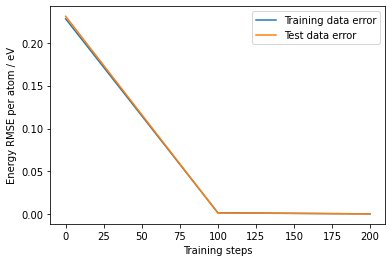

In [60]:
#checkpoints = [100, 500, 1000, 1500, 2000, 2500] # Change to the checkpoints that you want to plot
checkpoints = [0, 100, 200]
energy_rmse_train = []
energy_rmse_test = []

for checkpoint in checkpoints:
    print('Calculating training and test RMSEs for checkpoint {}'.format(checkpoint))
    calc = Amp.load('amp-checkpoints/{0}.amp'.format(str(checkpoint)), cores = 1)

    # Training set
    energy_loss = 0
    for i, atoms in enumerate(train_images):     
        E1 = atoms.get_potential_energy()
        a = atoms.copy()
        a.calc = calc
        E2 = a.get_potential_energy()
        Ediff = E1 - E2
        e_loss = np.square(Ediff / len(atoms))
        energy_loss += e_loss
    energy_rmse = np.sqrt(energy_loss / len(train_images))
    energy_rmse_train.append(energy_rmse)

    # Test (validation) set
    energy_loss = 0
    for i, atoms in enumerate(test_images):
        E1 = atoms.get_potential_energy()
        a = atoms.copy()
        a.calc = calc
        E2 = a.get_potential_energy()
        Ediff = E1 - E2
        e_loss = np.square(Ediff / len(atoms))
        energy_loss += e_loss
    energy_rmse = np.sqrt(energy_loss / len(test_images))
    energy_rmse_test.append(energy_rmse)

plt.plot(checkpoints, energy_rmse_train, label='Training data error')
plt.plot(checkpoints, energy_rmse_test, label='Test data error')
plt.legend()
plt.xlabel('Training steps')
plt.ylabel('Energy RMSE per atom / eV')
plt.show()

### Step 4: Performance on an independent test set
To further test the quality of our fitted ML potential, we prepared an independent test set consists of 5 representative nanoalloys.

First, let's visualize these 5 nanoalloys

In [64]:
ind_images = read('independent_test.traj', index=':')
view(ind_images)

/zhome/43/5/58576/bike-2021-venv-GA-AMP/lib/python3.6/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


Now let's calculate the average energy error (RMSE) predicted by our final ML potential

In [65]:
calc = Amp.load('amp-checkpoints/200.amp', cores = 1)
energy_loss = 0
for i, atoms in enumerate(ind_images):
    E1 = atoms.get_potential_energy()
    a = atoms.copy()
    a.calc = calc
    E2 = a.get_potential_energy()
    Ediff = E1 - E2
    e_loss = np.square(Ediff / len(atoms))
    energy_loss += e_loss
energy_rmse = np.sqrt(energy_loss / len(ind_images))
print(energy_rmse)

0.15578356997380363


Is the accuracy of the ML potential good enough? If not, try to improve it.

## References
[1] A. Khorshidi, A.A. Peterson, Comput. Phys. Commun. 207 (2016) 310–324. <br>
[2] Peterson AA, Christensen R, Khorshidi A: Phys Chem Chem Phys 2017, 19:10978–10985. <br>
[3] J. P. Perdew, K. Burke, and M. Ernzerhof, Phys. Rev. Lett. 77, 3865 1996. <br>
[4] G. Kresse and J. Hafner, Phys. Rev. B, vol. 47, pp. 558–561, Jan 1993. <br>
[5] A. H. Larsen, J. J. Mortensen, J. Blomqvist, I. E. Castelli, R. Christensen, M. Duak, J. Friis, M. N. Groves, B. Hammer, C. Hargus, E. D. Hermes, P. C. Jennings, P. B. Jensen, J. K., J. R. Kitchin, E. L. Kolsbjerg, J. Kubal, K. Kaasbjerg, S. Lysgaard, J. B. Maronsson, T. Maxson, T. Olsen, L. Pastewka, A. Peterson, C. Rostgaard, J. Schiøtz, O. Schütt, M. Strange, K. S. Thygesen, T. Vegge, L. Vilhelmsen, M. Walter, Z. Zeng, and K. W. Jacobsen,” Journal of Physics: Condensed Matter, vol. 29, no. 27, pp. 273002, 2017. <br>
[6] J. Behler, International Journal of Quantum Chemistry, vol. 115, no. 16, pp. 1032–1050, 2015.